http://cocodataset.org/#download

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from cv2 import filter2D

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# ids = next(os.walk("data/images"))[2] # list of names all images in the given path
# ids_m = next(os.walk("data/masks"))[2] # list of names all images in the given path
# # ids = ids[:1000]
# # ids_m = ids_m[:1000]

# print("No. of images = ", len(ids))

No. of images =  5100


In [3]:
im_width = 256
im_height = 256
border = 5

In [4]:
# X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
# y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [5]:
# kernel_size = 5
# kernel = -1 * np.ones((kernel_size, kernel_size))
# kernel[kernel_size // 2 + 1, kernel_size// 2 + 1] = kernel_size ** 2 - 1

# for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
#     # Load images
#     img = load_img("data/images/"+id_, grayscale=True)
#     x_img = img_to_array(img)
#     x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
#     # Load masks
#     mask = img_to_array(load_img("data/masks/"+ id_[:-4] + '.png', color_mode = "grayscale"))
#     mask = filter2D(mask, -1, kernel)
#     mask[mask!=0] = 1
#     mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
#     # Save images
#     X[n] = x_img/255.0
#     y[n] = mask/255.0
    
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [10]:
# np.save('xtrain', X_train)
# np.save('ytrain', y_train)
# np.save('xvalid', X_valid)
# np.save('yvalid', y_valid)

In [9]:
X_train = np.load('xtrain.npy')
X_valid = np.load('xvalid.npy')
y_train = np.load('ytrain.npy')
y_valid = np.load('yvalid.npy')

True

In [78]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [79]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [80]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 256, 256, 16) 64          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 256, 256, 16) 0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 32, 32, 256)  0           conv2d_transpose_9[0][0]         
                                                                 activation_44[0][0]              
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 32, 32, 256)  0           concatenate_9[0][0]              
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 32, 32, 128)  295040      dropout_21[0][0]                 
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 32, 32, 128)  512         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation

In [81]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=20, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))


Train on 4590 samples, validate on 510 samples
Epoch 1/20


In [70]:
img = load_img("samples/apples.jpg", color_mode = "grayscale")
img = img_to_array(img)
img = resize(img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)

In [71]:
answer = model.predict(img[np.newaxis,...])

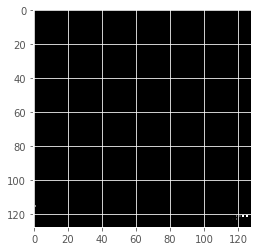

In [73]:
plt.imshow(answer[0,...,0], cmap='gray')